In [26]:
import tensorflow as tf
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
building_dir = './mass_buildings'
os.listdir(building_dir)

['.DS_Store', 'test', 'train']

In [19]:
def load_image_paths(path,name):
    
    #images-to-path dierctory
    images= {name: {'train': defaultdict(dict), 'test': defaultdict(dict), 'valid': defaultdict(dict)}}
    
    #taking out the .ds stores that mac has
    ttv = [f for f in os.listdir(path) if '.DS_Store' not in f]
    
    
    for ttv_typ in ttv:
        #joining path to train/test folders
        typ_path = os.path.join(path, ttv_typ)
        
        mapsat = [f for f in os.listdir(typ_path) if '.DS_Store' not in f]
        
        for ms_typ in mapsat:
            # for each folder (train,test) get the image paths
            ms_path = os.path.join(typ_path, ms_typ)
            ms_img_files = os.listdir(ms_path)
            
            #keep only tif
            ms_img_files = [f for f in ms_img_files if f.endswith('.tiff') or f.endswith('.tif')]
            
            # get the image id (take off tif ending)
            scene_ids = [f.replace('.tiff','').replace('.tif','') for f in ms_img_files]
            
            
            #joining the whole path
            ms_img_files = [os.path.join(ms_path,f) for f in ms_img_files]
            
            #FILLING OUT IMAGES-TO-PATH DICTIONARY
            for f, scene_id in zip(ms_img_files,scene_ids):
                images[name][ttv_typ][scene_id][ms_typ] = f
                
    return images

In [20]:
def show_images(x,y):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    m = plt.imshow(x)
    plt.colorbar(m, fraction=.046,pad=0.04)
    
    plt.subplot(1,2,2)
    m = plt.imshow(y[:,:,0], vmin=0,vmax=1)
    plt.colorbar(m, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [21]:
images = load_image_paths(building_dir, 'roads')

In [28]:
def data_generator(files, size=256, mode ='train', batch_size=32):
    while True:
        all_scenes = list(files[mode].keys())
        
        scene_id = np.random.choice(all_scenes, size=batch_size, replace=True)
        # these are raw image data to be fed through PIL.Image
        X_files = [files[mode][scene_i]['sat'] for scene_i in scene_id]
        Y_files = [files[mode][scene_i]['map'] for scene_i in scene_id]
        
        X = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in X_files])
        Y = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in Y_files])
        
        n, h, w, c = X.shape
        
        #choosing random block from the huge image for data conservation
        I = np.random.randint(0,h-size, size=batch_size)
        J = np.random.randint(0,w-size,size=batch_size)
        
        X = np.array([x[i:(i+size),j:(j+size)] for x, i, j in zip(X,I,J)])
        Y = np.array([y[i:(i+size),j:(j+size)] for y, i, j in zip(Y,I,J)])
        
        yield X, np.expand_dims(Y,axis=-1)

In [29]:
train_road_gen = data_generator(images['roads'])

In [30]:
X,Y = next(train_road_gen)

<ipython-input-28-599b85a821d7>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in X_files])
<ipython-input-28-599b85a821d7>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in Y_files])


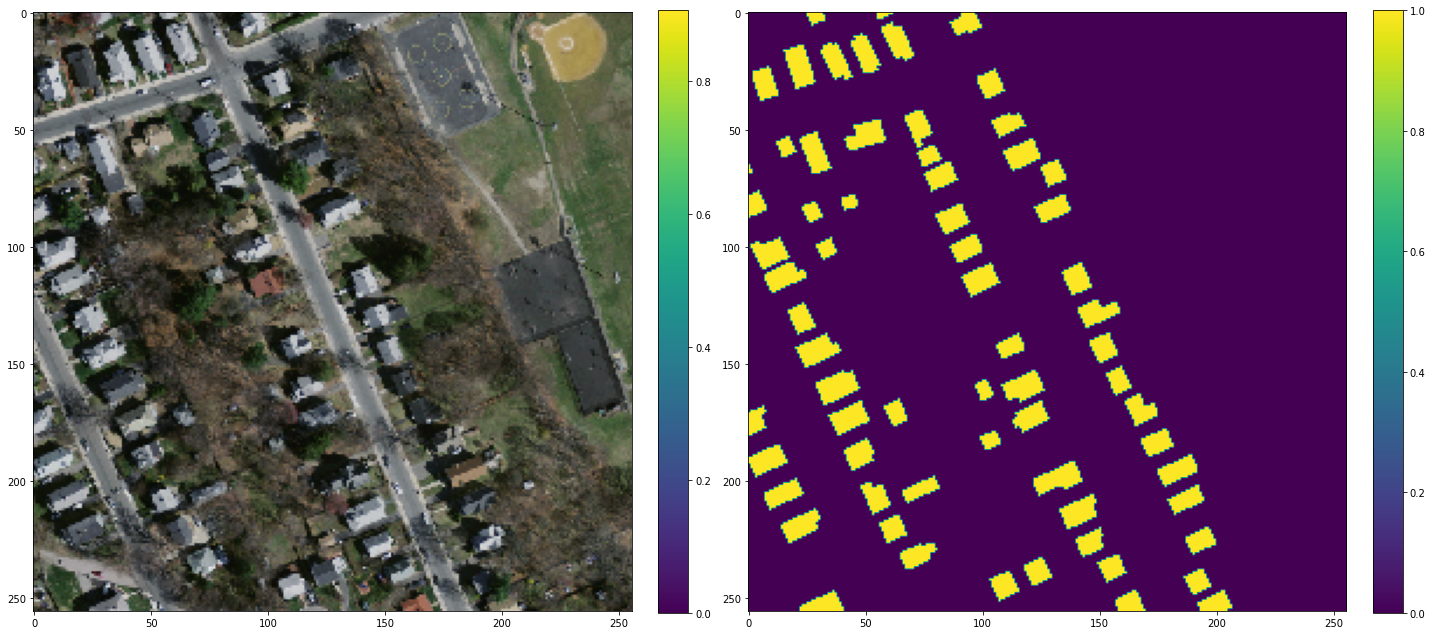

In [32]:
show_images(X[0],Y[0])

# Trying to code a U-Net architecture off of a diagram

## testing my ability to code a complex NN without a template

In [38]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv1D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD